---
execute:
    echo: false
    warning: false

format:
    html:
        themes: "theme_ipol.scss"
        self-contained: true
---

In [165]:
n_nodes = 78 #@param {type:"slider", min:2, max:300, step:1}
prob_law = "weibull" #@param ["log_normal", "gaussian", "poisson", "uniform", "laplacian", "pareto", "weibull"]
feature_dims = 10 #@param {type:"slider", min:10, max:100, step:1}


In [166]:
n_montecarlo = 1
gamma_list = [1.2, 1., 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

In [167]:
import numpy as np
import scipy
import random
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import Ridge, RidgeCV
from scipy.stats import lognorm, poisson, uniform, norm, randint, weibull_min, laplace, pareto
from matplotlib import rc
import os
#import pandas as pd
#import plotly.express as px
#from plotly import graph_objects as go, io as pio
#pio.renderers.default='notebook_connected'

In [168]:
mpl.style.use('seaborn-darkgrid')
mpl.style.use('seaborn-pastel')
mpl.rcParams['font.size'] = 15

In [169]:
#synthetize data of dimension d for all M nodes, where n is the sample size vector
def synt_data(M, d, n):
    theta_star = np.random.uniform(size = d)
    x = []
    y = []
    for i in range(M):
        x_i = np.random.normal(loc = 0, scale = 1., size = (n[i], d))
        x.append(x_i)
        y_i = x_i @ theta_star + np.random.normal(loc = 0, scale = 1., size = n[i])
        y.append(y_i)
    return x, y, theta_star

def get_law_data_nodes(prob_law, n_nodes, gamma):
    
    if prob_law == 'gaussian':
        law_datanodes = norm.rvs(n_nodes**gamma, 0.1*n_nodes**gamma, size=n_nodes)
    elif prob_law == 'log_normal':
        law_datanodes = lognorm.rvs(1, scale = (n_nodes**gamma)*np.exp(-1/2), size = n_nodes)
    elif prob_law == 'poisson':
        law_datanodes = poisson.rvs(n_nodes**gamma, size=n_nodes)
    elif prob_law == 'uniform':
        law_datanodes = randint.rvs(0, 2*n_nodes**gamma, size=n_nodes)
    elif prob_law == 'laplacian':
        law_datanodes = laplace.rvs(loc=n_nodes**gamma, scale=0.1*n_nodes**gamma, size=n_nodes)
    elif prob_law == 'pareto':
        law_datanodes = pareto.rvs(b=2, scale=n_nodes**gamma/2, size=n_nodes)
    elif prob_law == 'weibull':
        law_datanodes = weibull_min.rvs(c=1.5, scale=n_nodes**gamma/math.gamma(1+1/1.5), size=n_nodes)
    else:
        raise NotImplementedError

    for i in range(n_nodes):
        #to ensure that the sample size is at least 1
        law_datanodes[i] = max(1, law_datanodes[i])

    return law_datanodes.astype(int)


#compute the weights derived from the solution of the optimization problem
def weights(a, b):
    M = len(a)
    k = 0
    ord_b = np.sort(b)
    ord_ind = np.argsort(b)
    weights = np.zeros(M)
    temp_ab = ord_b[0]/a[ord_ind[0]]
    temp_a = 1./a[ord_ind[0]]
    sum_ord_ab = 0
    sum_ord_a = 0
    while ord_b[k] <= (2 + temp_ab) / (temp_a):
        sum_ord_ab += ord_b[k]/a[ord_ind[k]]
        sum_ord_a += 1./a[ord_ind[k]]
        if k == M-1:
            break
        k += 1
        temp_ab = sum_ord_ab + ord_b[k]/a[ord_ind[k]]
        temp_a = sum_ord_a + 1./a[ord_ind[k]]
    for i in range(k):
        ind = ord_ind[i]
        weights[ind] = - 0.5*b[ind]/a[ind] + 1./a[ind]*(1. + 0.5*sum_ord_ab)/sum_ord_a
    return weights

def repro_vary(montecarlo_rounds, n_nodes, feature_dims, gamma_list, prob_law):
    
    # initialization
    n_gammas = len(gamma_list)
    sco_theta = np.zeros(n_gammas)
    sco_theta_s = np.zeros(n_gammas)
    sco_theta_GP = np.zeros(n_gammas)
    
    for gamma_idx, gamma in enumerate(gamma_list):                
        #for each gamma, where the sample size expectation is equal to M^gamma
        for k in range(montecarlo_rounds):
            
            # generate number of samples per client
            samples_per_node = get_law_data_nodes(prob_law, n_nodes, gamma)
            lamb = 1./np.sqrt(np.sum(samples_per_node))

            if gamma_idx == 0:
              # plot the samples per node distribution only for gamma=1.2
              samples_per_node_to_plot = samples_per_node
            
            # generate data and labels
            x, y, theta_star = synt_data(n_nodes, feature_dims, samples_per_node)
            clf = Ridge(alpha = lamb)
            clf.fit(np.concatenate(x), np.concatenate(y))
            theta = clf.coef_
            theta_nodes = np.zeros((n_nodes, feature_dims))
            
            # local steps in all the nodes
            for i,[xi,yi] in enumerate(zip(x,y)):
                #lamb = 1./np.sqrt(n[i])
                clf = Ridge(alpha = lamb)
                clf.fit(xi, yi)
                theta_nodes[i] = clf.coef_
                
            # server aggregation
            theta_s = np.dot(samples_per_node/np.sum(samples_per_node), theta_nodes)     #theta with weights proportional to the sample size
            weights_GP = weights(1./samples_per_node, 1./samples_per_node**2)            #weights obtained for theta "Good Practice"
            theta_GP = np.dot(weights_GP, theta_nodes)
            
            sco_theta[gamma_idx] += 1./montecarlo_rounds*np.linalg.norm(theta - theta_star, 2)**2.
            sco_theta_s[gamma_idx] += 1./montecarlo_rounds*np.linalg.norm(theta_s - theta_star, 2)**2.
            sco_theta_GP[gamma_idx] += 1./montecarlo_rounds*np.linalg.norm(theta_GP - theta_star, 2)**2.
            
    return sco_theta, sco_theta_s, sco_theta_GP, samples_per_node_to_plot

In [163]:
def plot_nodes_histogram(samples_per_node):

    '''
    df = pd.DataFrame(samples_per_node, columns=['samples_per_node'])
    fig = px.histogram(df, x='samples_per_node')
    return fig
    '''
    plt.figure()
    plt.hist(samples_per_node, bins=80)
    plt.xlabel("# samples per node")
    plt.title('Samples per node histogram')
    plt.grid('on')
    #plt.savefig('nodes_hist.png', dpi=300, bbox_inches='tight')
    
def plot_and_save(a, gammas, n_nodes):

    plt.figure()
    mean_samples_per_node = [n_nodes**g for g in gammas]
    plt.plot(mean_samples_per_node, a[0], '+-', label = "Centralized")
    plt.plot(mean_samples_per_node, a[1], '+-', label = "Federated")
    plt.plot(mean_samples_per_node, a[2], '+-',label = "FESC")
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.xlabel("Mean # samples per node")
    plt.ylabel("MSE")
    plt.grid('on')
    #plt.savefig('this_is_not_the_output.png', dpi=300, bbox_inches='tight')

def plot_images(a, gammas, n_nodes, samples_per_node):

    # samples per node histogram
    f = plt.figure(figsize=(14,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    weights = np.ones_like(samples_per_node)/float(len(samples_per_node))
    ax1.hist(samples_per_node, bins=int(0.2*n_nodes), weights=weights)
    ax1.set_xlabel("number of samples per node")
    ax1.set_ylabel("frequency")
    ax1.set_title('samples per node histogram')
    ax1.grid('on')

    # output image
    ax2.plot(gammas, a[0], '+-', label = "Centralized")
    ax2.plot(gammas, a[1], '+-', label = "Federated")
    ax2.plot(gammas, a[2], '+-',label = "FESC")
    ax2.set_yscale('log')
    ax2.legend()
    ax2.set_xlabel("gamma")
    ax2.set_title('MSE vs mean samples per node')
    ax2.set_ylabel("mean square error (MSE)")
    ax2.grid('on')

    plt.tight_layout()

In [164]:
sco_theta, sco_theta_s, sco_theta_GP, samples_per_node = repro_vary(n_montecarlo, n_nodes, feature_dims, gamma_list, prob_law)

::: {.column-screen}

In [170]:
print('You need at least {} samples (in average) per node to equal the performance of a centralized training with Federated Learning'.format(n_nodes))

You need at least 78 samples (in average) per node to equal the performance of a centralized training with Federated Learning


:::

::: {.column-screen}

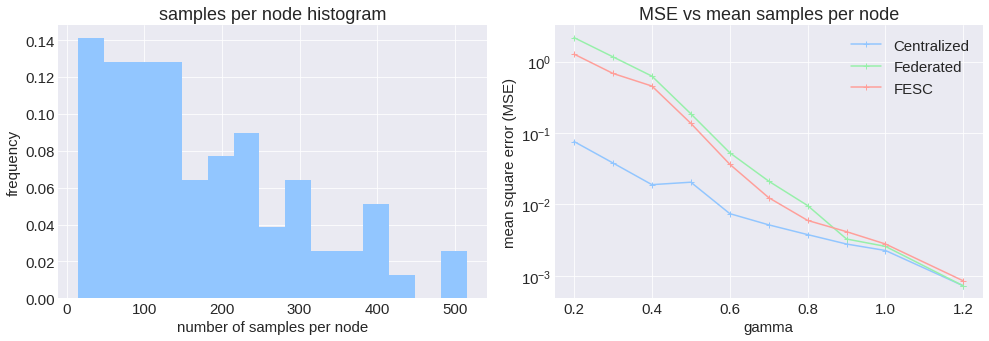

In [158]:
plot_images([sco_theta, sco_theta_s, sco_theta_GP], gamma_list, n_nodes, samples_per_node)

:::